<h1> End-to-end Example of a Machine Learning Pipeline for Imbalanced Data - Part II </h1>

Now that we have imputed and selected a 'potential' model, let's build on it using the properties of our data. 

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#read">Reading and examining the data</a></li>
        <li><a href="#imbalance">'Scope out' different techniques for handling imbalance </a></li>
        <li><a href="#tune">Tune the hyperparameters for the selected approach</a></li>
        <li><a href="#validate">Cross-validate to establish confidence</a></li>
    </ol>
</div>
<br>
<hr>

<h2 id="read">Reading and examining the data</h2>


In [243]:
import pandas as pd

path_to_file ="/Users/babylon/Documents/Teaching/ML/ML2022/Week2/FavouriteData.csv"
pima_data = pd.read_csv(path_to_file, encoding='utf-8')

Double check that we have the scaled & imputed dataset

In [244]:
pima_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.468243,0.862287,-0.032746,0.558557,-0.072061,0.165097,0.468492,1.425995,1
1,-1.087043,-1.202229,-0.517645,-0.014657,-0.893978,-0.846404,-0.365061,-0.190672,0
2,1.090358,2.009241,-0.679278,0.797396,0.606548,-1.323254,0.604397,-0.105584,1
3,-1.087043,-1.071148,-0.517645,-0.587871,-0.518847,-0.629654,-0.920763,-1.041549,0
4,-0.775986,0.501816,-2.618874,0.558557,0.104968,1.537847,5.484909,-0.020496,1


In [245]:
pima_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,7.680000e+02,7.680000e+02,768.000000
mean,-0.028112,-0.003560,-0.000072,-0.009868,-0.023962,-0.000401,2.451743e-16,1.838807e-16,0.348958
std,0.958000,0.999097,0.990833,0.935252,0.880537,0.995225,1.000652e+00,1.000652e+00,0.476951
min,-1.087043,-2.545803,-3.911938,-2.116442,-1.193241,-2.060204,-1.189553e+00,-1.041549e+00,0.000000
25%,-0.775986,-0.743447,-0.679278,-0.683407,-0.613684,-0.716354,-6.889685e-01,-7.862862e-01,0.000000
50%,-0.153872,-0.153586,-0.032746,-0.014657,-0.249089,-0.022754,-3.001282e-01,-3.608474e-01,0.000000
75%,0.468243,0.608319,0.613787,0.618267,0.290426,0.598597,4.662269e-01,6.602056e-01,1.000000
max,3.889873,2.533562,4.008080,6.672840,5.820456,5.005848,5.883565e+00,4.063716e+00,1.000000


Construct X and y (I will call X, X_original as I will be updating it as the practical goes on)

In [246]:
X_original = pima_data[["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]]
y = pima_data["Outcome"]


- Let's examine the distribution of the outcome y


<b> Your Task: </b>

    - As in previous practicals, plot a pie chart to show the distribution of the outcome y. 
    - Guidance: 
        - y.value_count() gets you the total count of each possible y value. 
        - Here's an example from matplot lib to help you get started (if you don't want to look at previous practicals): 
            - Link: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
            - You don't have to use explode or axes as the example does, because we're plotting a simple chart. 
    

In [1]:
## Your solution here ##


- Note that if you don't want to plot, you can always use counter to give you an idea as in below: 

In [248]:
##check the size of the data: 
from collections import Counter 
counter = Counter(y)
print(counter)


Counter({0: 500, 1: 268})


- Let's also recap our favourite model from the previous practical 
- You can also save this model, more on this later. 

In [249]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_original, y, test_size = 0.2, random_state = 42)

#Feed data into Random Forest Algorithm
clf1 = RandomForestClassifier(random_state=42)
clf1.fit(X_train, y_train)
y_pred = clf1.predict(X_test)

#Check performance
print(" Classification report of RF using KNN Imputation : ")
print(classification_report(y_test,y_pred))



 Classification report of RF using KNN Imputation : 
              precision    recall  f1-score   support

           0       0.83      0.82      0.82        99
           1       0.68      0.69      0.68        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154



<h2 id="imbalance">'Scope out' different techniques for handling imbalance </h2>

- Now that we have: 
    1. A favourite classifer
    2. Knowledge of the class imbalance
- Let's try to improve our performance
    - We care a lot about the minority class (Outcome = 1)
    - Although the classifier's performance on the majority is okayish, we'd like to do better on the minority. 


<h3> Approach 1: Weighted Classification </h3> 

- Idea: inform the classifer that different classes have different weights. 
    - The classifier then assigns different penalty rations for misclassifying the different classes. 
    - The idea/hope is that if the classifier is penalised more when misclassifying the minority class, it will work harder to avoid this penalty. 
    
- But how do we choose the class weights?
- The class weighing can be defined multiple ways; for example:

    - Domain expertise, determined by talking to subject matter experts.
    - Tuning, determined by a hyperparameter search such as a grid search.
    - Heuristic, specified using a general best practice.

- A best practice for using the class weighting is to use the inverse of the class distribution present in the training dataset.
        -We can use the counter to establish the weights. 
            - As the counter shows (below), the number of samples in the minority class is approximately half of the number of samples in the majority class


    

In [250]:
from collections import Counter
counter = Counter(y_train)
print(counter)



Counter({0: 401, 1: 213})


- With weighted classification, all you have to do is update the 'class_weight' parameter of the classifier. 
- class_weight takes a dictionary item, which we constructed based on the results of our counter

In [251]:
#class weights
weights = {0:0.5, 1:1.0}
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_original, y, test_size = 0.2, random_state = 42)

#Feed data into Random Forest Algorithm, note the class weight parameter!
clf1 = RandomForestClassifier(class_weight = weights, random_state=42)
clf1.fit(X_train, y_train)
y_pred = clf1.predict(X_test)

#Check performance
print(" Classification report of RF using KNN Imputation and class weights : ")
print(classification_report(y_test,y_pred))



 Classification report of RF using KNN Imputation and class weights : 
              precision    recall  f1-score   support

           0       0.83      0.84      0.83        99
           1       0.70      0.69      0.70        55

    accuracy                           0.79       154
   macro avg       0.77      0.76      0.77       154
weighted avg       0.78      0.79      0.79       154



- A minor improvement - can we do better? let's try other approaches

<h3> Approach 2: SMOTE</h3> 

- There's a beautiful package called imblearn (imbalanced learning). 
- I highly encourage you to explore its documentation and get to know it better. 
- imblearn implements SMOTE (Synthetic Minority Oversampling TEchnique) is a very popular oversampling method that generates synthetic data from the minority class to match the number of samples in the majority class
- imblearn documentation: https://imbalanced-learn.org/stable/
- You may have to install it - as before, from your conda prompt: pip install imblear 
- I will help you in smoting your data, your job is to build the classifier and test it. 

In [252]:
import imblearn
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X_original, y, test_size = 0.2, random_state = 42)

oversample = SMOTE()
X_train_smoted, y_train_smoted = oversample.fit_resample(X_train, y_train)

#check the size of the data after SMOTing: 
counter = Counter(y_train_smoted)
print(counter)


Counter({0: 401, 1: 401})


They're equal :) 


<b> Your Task </b> 
- Build a new classifier, call it clf2
- clf2 is trained on the smoted data (both X and y)
- use it to predict y_pred for X_test
- Output the classification report. 

In [2]:
#### Your solution here #####



<h4> Approach 3: stratified sampling </h4> 
    

In [255]:
#class weights
weights = {0:0.5, 1:1.0}
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_original, y, stratify=y, test_size = 0.2, random_state = 42)

#Feed data into Random Forest Algorithm, note the class weight parameter!
clf3 = RandomForestClassifier(class_weight = weights, random_state=42)
clf3.fit(X_train, y_train)
y_pred = clf3.predict(X_test)

#Check performance
print(" Classification report of RF using KNN Imputation and class weights : ")
print(classification_report(y_test,y_pred))


 Classification report of RF using KNN Imputation and class weights : 
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       100
           1       0.68      0.50      0.57        54

    accuracy                           0.74       154
   macro avg       0.72      0.69      0.69       154
weighted avg       0.73      0.74      0.73       154



<h4> Approach 4: combine over and undersampling </h4>

- The imblearn library has a really nice feature called 'pipelin' 
    - https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html
- Pipeline allows you to combine multiple steps (in our case: smoting the minority and undersampling the majority)
- Go through the steps of this code to undersatnd what it's doing

In [256]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(X_original, y, test_size = 0.2, random_state = 42)

model = RandomForestClassifier(random_state=42)
over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='majority')

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_overunder, y_overunder = pipeline.fit_resample(X_train, y_train)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from numpy import mean

model.fit(X_overunder , y_overunder ) 

y_predicted = model.predict(X_test)
print(" Classification report of RF with Over & Undersampling : ")
print(classification_report(y_test ,y_predicted))


 Classification report of RF with Over & Undersampling : 
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        99
           1       0.62      0.73      0.67        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154



- Which classifier performed better?
- In my case, it depended on the run (I ran all multiple times), but:
    - the stratified model that uses class weights performed consistently badly. 
    - The combination of over and undersampling improved recall (on the minority class), but hindered precision. 
    - So, we'll proceed in selecting between weighted classification and smoting on its own
- We'll deal with the issue of selecting which model using cross validation (choice between smoting and class weights)

In [257]:

from sklearn.model_selection import GridSearchCV, cross_val_score 


clf1 = RandomForestClassifier(class_weight = weights, random_state=42)
##Ask me: why did we re-initialise the classifer, clf1??

classifier_grid = GridSearchCV(estimator=clf1, param_grid ={}, cv=7)
#### see how I left: param_grid empty, because we want to worry about hyperparmeter tuning later. 
#### param_grid is a mandatory argument, so I couldn't discard it alltogether. 


classifier_grid.fit(X_train, y_train)
best_model1 = classifier_grid.best_estimator_
y_pred= best_model1.predict(X_test)
print(classification_report(y_test, y_pred))
                    


              precision    recall  f1-score   support

           0       0.83      0.84      0.83        99
           1       0.70      0.69      0.70        55

    accuracy                           0.79       154
   macro avg       0.77      0.76      0.77       154
weighted avg       0.78      0.79      0.79       154



<b> Your Task: </b> Do the same for clf2 using X_smoted and y_smoted

In [3]:
#### Your solution here #####


- Let's plot variable importance to see if there's any  difference

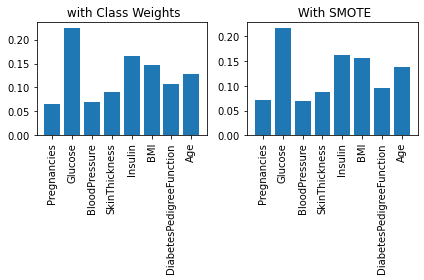

In [230]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)

clf1_vector = best_model1.feature_importances_
clf2_vector = best_model2.feature_importances_

feature_names=X_original.columns

# Set the ticks and ticklabels for all axes
plt.setp(axes, xticks=range(len(clf1_vector)), xticklabels= clf1_vector)

# Use the pyplot interface to change just one subplot...
axes[0].bar(range(len(clf1_vector)), clf1_vector)
axes[1].bar(range(len(clf2_vector)), clf2_vector)

axes[0].set_xticklabels(feature_names, rotation='vertical' )
axes[1].set_xticklabels(feature_names, rotation='vertical' )

axes[0].set_title(' with Class Weights')
axes[1].set_title(' With SMOTE')

fig.tight_layout()
plt.show()

- It looks like using class weights provides a slightly more uniform distribution of variable importance
- Let's see if selecting the most important variables makes a difference on performance
- Let'see if we can further improve the model via feature selection


- sklearn has a nice subpackage called SelectFromModel
- The code below shows you how to use it. 

In [231]:
from sklearn.feature_selection import SelectFromModel

# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.10 (guestimating from the importance plots)

sfm = SelectFromModel(best_model1, threshold=0.07)

# Train the selector
sfm.fit(X_train, y_train)
feature_names=X_original.columns

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feature_names[feature_list_index])
    
    
# Create A Data Subset With Only The Most Important Features

# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

clf_important = RandomForestClassifier(random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

y_pred = clf_important.predict(X_important_test)

#Check performance
print(" Classification report of RF using KNN Imputation, weighted classification AND feature selection  : ")
print(classification_report(y_test,y_pred))


Glucose
SkinThickness
Insulin
BMI
DiabetesPedigreeFunction
Age
 Classification report of RF using KNN Imputation, weighted classification AND feature selection  : 
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        99
           1       0.67      0.67      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154



- In my case, the performance went down. 
- This is directly related to the fact that the importance of the features are more or less uniformly distributed. 

- Let's see if we can tune the hyperparameters of the best classifier so far (best_model1)

In [232]:
from sklearn.model_selection import GridSearchCV, cross_val_score 
from pprint import pprint 

In [233]:
print('Parameters currently in use:\n')
pprint(best_model1.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': {0: 0.5, 1: 1.0},
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [234]:
parameter_grid = {
            "min_samples_leaf": [1, 5, 20, 50],
            'n_estimators': [20, 60, 100,200],
             'max_features' : [3,5,8],
            'criterion': ['gini', 'entropy']
}

classifier_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameter_grid, cv=7)
classifier_grid.fit(X_train, y_train)


GridSearchCV(cv=7, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [3, 5, 8],
                         'min_samples_leaf': [1, 5, 20, 50],
                         'n_estimators': [20, 60, 100, 200]})

In [235]:
print(" The best parameters found are: ")
print(classifier_grid.best_params_)

best_model = classifier_grid.best_estimator_

 The best parameters found are: 
{'criterion': 'gini', 'max_features': 3, 'min_samples_leaf': 20, 'n_estimators': 20}


In [236]:
y_pred= best_model.predict(X_test)

In [237]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82        99
           1       0.68      0.65      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.76      0.77      0.77       154



<b> Your Task: </b> 
- Let's also tune the Smoted model, just to be sure

In [4]:
# # # Your solution here # # # 

<b> Final Step </b>
-After all of the experiments, we need to make sure that the best model is robust.
-  Cross validation achieved the robustness. The fact that precision and recall are comparable to accuracy gives us some confidence. 
- But hyperparameter tuning didn't do so well, so we'll just revert to best_model1 (which is weighted classification using CV):
- Establish the confidence in the final model using Repeated Stratified Cross Validation (stratify the folds and repeat the experiments of cross validation). 

In [258]:
# Define evaluation procedure (here we use Repeated Stratified K-Fold CV)
cv_def=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scoring=['accuracy','precision_macro','recall_macro']

final_scores = cross_validate(best_model1, X_original, y, scoring=scoring, cv=cv_def, n_jobs=-1)

# summarize performance
print('Mean Accuracy: %.4f' % np.mean(final_scores['test_accuracy']))
print('Mean Precision: %.4f' % np.mean(final_scores['test_precision_macro']))
print('Mean Recall: %.4f' % np.mean(final_scores['test_recall_macro']))


Mean Accuracy: 0.7543
Mean Precision: 0.7345
Mean Recall: 0.7101


<h2 id="save">Saving the model</h2>
- sklearn provdies a nice feature- enables saving the model. 
- This is how you re-use your models without having to retrain!
- Let's save our model

In [260]:
import pickle

filename = 'BestModel.sav'
pickle.dump(best_model1, open(filename, 'wb'))


- You'll see your model int he current folder :) 
- You can load your model in future notebooks using pickle.load()
- Read more here: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/